<a href="https://colab.research.google.com/github/matteo-mariotti/captcha-solver/blob/main/Captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/matteo-mariotti/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 38698, done.
remote: Counting objects: 100% (38698/38698), done.
remote: Compressing objects: 100% (38695/38695), done.
remote: Total 38698 (delta 5), reused 38696 (delta 3), pack-reused 0
Receiving objects: 100% (38698/38698), 28.81 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (38795/38795), done.


In [2]:
! ls datasets

dataset  dataset_1.csv	dataset_2.csv  datasetN2


In [3]:
# import Dataset class from pytorch
from torch.utils.data import Dataset
import pandas as pd
import os
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision

# create a class for the dataset
class CaptchaDataset_1(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    # return the length of the dataset
    def __len__(self):
        return len(self.annotations)
    
    # return the item at the index
    def __getitem__(self, index):
        if torch.is_tensor(index):
          index = index.tolist()
        # get the image name from the csv file
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 0]) + '.png')
        # read the image using cv2
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # get the label from the csv file
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        # return the image and the label

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [7]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn

# Define the model
class ReteNeurale(nn.Module):
    def __init__(self):
        super(ReteNeurale, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.Dropout = nn.Dropout(0.4)
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2)
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(1600, 256)
        self.fc2 = nn.Linear(256, 36)

    def forward(self, x):
        x = self.batchNorm1(nn.functional.relu(self.conv1(x)))
        x = self.batchNorm2(nn.functional.relu(self.conv2(x)))
        x = self.pool(self.batchNorm3(nn.functional.relu(self.conv3(x))))
        x = x.view(-1, 1600)
        x = nn.functional.relu(self.fc1(x))
        x = self.Dropout(x)
        x = self.fc2(x)
        return x
    
# Load the data
dataset = CaptchaDataset_1(csv_file='datasets/dataset_1.csv', root_dir='datasets/dataset/', transform=transforms.ToTensor())

train_set, test_set = torch.utils.data.random_split(dataset, [8560, 2140])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

# Create the model
model = ReteNeurale().to("cuda")

# Define the hyperparameters
learning_rate = 0.001
num_epochs = 30

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)

accValues = []
train_losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to("cuda")
        labels = labels.to("cuda")

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


                # Test the model
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images.to("cuda")
            labels = labels.to("cuda")
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        
        acc = 100.0 * n_correct / n_samples
        print(n_correct, n_samples)
        print(f'Accuracy of the network: {acc} %')

print('Finished Training')

# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(n_correct, n_samples)
    print(f'Accuracy of the network: {acc} %')

Epoch [1/30], Step [100/268], Loss: 3.2755
Epoch [1/30], Step [200/268], Loss: 2.9617
316 2140
Accuracy of the network: 14.766355140186915 %
Epoch [2/30], Step [100/268], Loss: 2.8195
Epoch [2/30], Step [200/268], Loss: 2.6043
515 2140
Accuracy of the network: 24.065420560747665 %
Epoch [3/30], Step [100/268], Loss: 2.5171
Epoch [3/30], Step [200/268], Loss: 2.4896
716 2140
Accuracy of the network: 33.45794392523364 %
Epoch [4/30], Step [100/268], Loss: 2.0271
Epoch [4/30], Step [200/268], Loss: 2.0098
866 2140
Accuracy of the network: 40.467289719626166 %
Epoch [5/30], Step [100/268], Loss: 2.0164
Epoch [5/30], Step [200/268], Loss: 2.0672
997 2140
Accuracy of the network: 46.58878504672897 %
Epoch [6/30], Step [100/268], Loss: 1.7102
Epoch [6/30], Step [200/268], Loss: 1.9353
1110 2140
Accuracy of the network: 51.86915887850467 %
Epoch [7/30], Step [100/268], Loss: 1.7142
Epoch [7/30], Step [200/268], Loss: 1.5801
1171 2140
Accuracy of the network: 54.7196261682243 %
Epoch [8/30], St

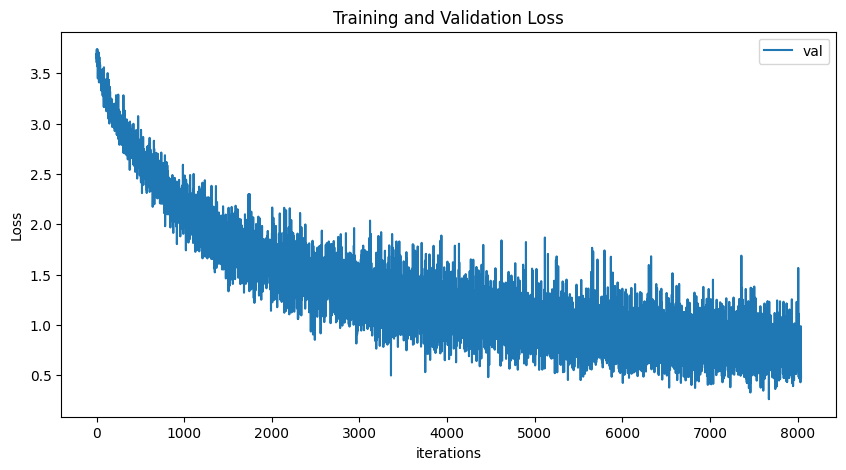

In [8]:
import matplotlib.pyplot as plt

val_losses = []

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()